In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pyrates.utility.grid_search import grid_search, ClusterGridSearch
warnings.filterwarnings("ignore")
%matplotlib inline

# Using PyRates' ClusterGridSearch class to run large-scale parameter studies


This section demonstrates how to use the `grid_search()` method and the `ClusterGridSearch` class from the `pyrates.utility` module to perform parameter sweeps on models in PyRates.
Below, you will find the code to run a parameter sweep on the Montbrio model described in detail in "Gast, R. et al. (2018) PyRates - A Python framework for neural modeling and simulations on parallel hardware". The Montbrio model is a mean-field model of a globally coupled population of quadratic integrate-and-fire neurons, initially proposed by Montbrio and colleagues in 2015: "Montbrio et al. (2015) ....". The PyRates model implementation can be found under templates/montbrio.

## Recapitulating the grid_search() function

The `grid_search()` function is a dedicated tool for parameter space investigations. It is optimized to run multiple instances of the same model with different parametrizations in parallel.
In the following example we simulate two coupled montbrio populations, representing a pyramid cell (PC) and an inhibitory inter neuron (IIN), respectively, for different excitability levels $\eta_{pc}$ and $\eta_{iin}$ of the respective population.
In addition to standard simulation parameters, `grid_search()` expects a `parameter_grid` and a `parameter_map` as 
function arguments.
In the `parameter grid`, multiple values can be specified for a single model parameter. The `parameter map` maps the values specified in the `parameter grid` to explicit model parameters defined in the `circuit template`. The model output of each parametrization is stored in the 'results' DataFrame, whereas the 'result_map' yields the actual parameter combinations of each parametrization.

building the compute graph...
Preparing the simulation...
Running the simulation...
5.0s of backend behavior were simulated in 6.2982423305511475 s given a simulation resolution of 0.0001 s.


,eta_op,eta_iin
circuit_0,-5.0,0.0
circuit_1,-4.0,1.0
circuit_2,-3.0,2.0
circuit_3,-2.0,3.0
circuit_4,-1.0,4.0


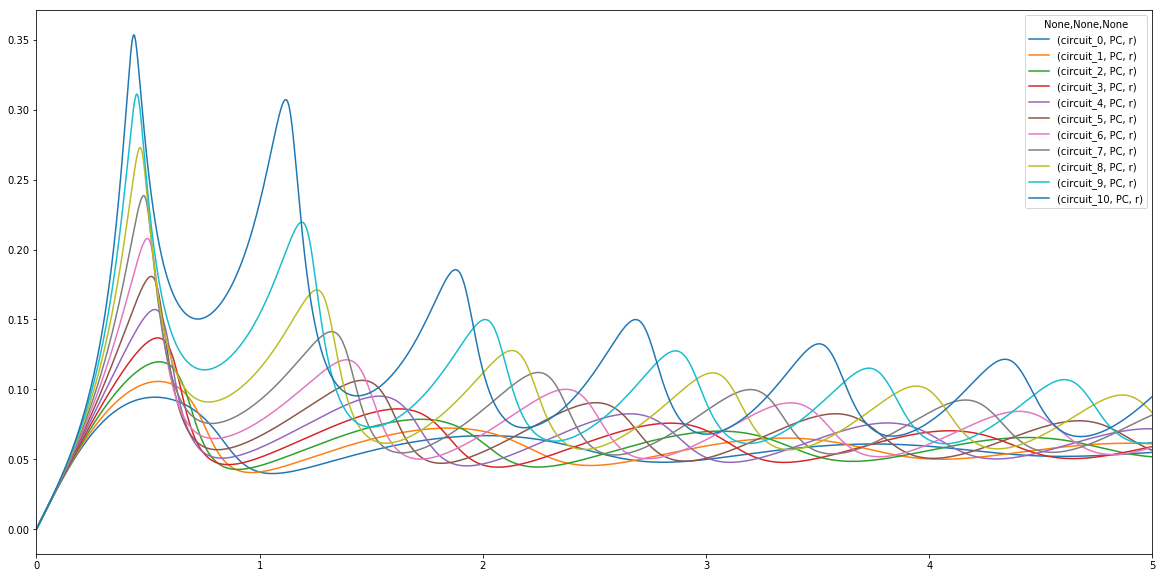

In [3]:
T = 5.
dt=1e-4

param_grid = {'eta_op': np.linspace(-5, 5, 11),
              'eta_iin': np.linspace(0, 10, 11)}

param_map = {'eta_op': {'vars': ['Op_e/eta'],
                        'nodes': ['PC']},
             'eta_iin': {'vars': ['Op_i/eta'],
                         'nodes': ['IIN']}}

results, result_map, t_ = grid_search(
    circuit_template="model_templates.montbrio.simple_montbrio.Net3",
    simulation_time=T,
    dt=dt,
    sampling_step_size=1e-3,
    inputs={"PC/Op_e/inp": np.ones((int(T/dt), 1))},
    outputs={'r': 'PC/Op_e/r'},
    param_grid=param_grid,
    param_map=param_map,
    permute_grid=False,                           # Creates all permutations of the param_grid values if set to True
    init_kwargs={                                 # Additional keyword arguments for the compute graph
        'backend': 'numpy',                       # Can be either 'numpy' or 'tensorflow'
        'solver': 'euler'                         # Solver for the differential equation approximation.
    },
    profile='t',                                  # Automated runtime tracking
    njit=True,                                    # Use Numba's njit compiler
    parallel=False
)

display(result_map.head())

plt.rcParams["figure.figsize"] = (20,10)
results.plot()

## ClusterGridSearch

The `ClusterGridSearch` class extends PyRates' tools for paremter space investigations with the ability to distribute computations among multiple workstation in a computer network.
This is especially useful when investigating high-dimensional parameter spaces that require large parameter grids that might exceed the hardware capacities of a single workstation.
The use of `ClusterGridSearch` requires the utilized computer network to feature two major properties:
1. A GSSAPI-based authentication method (e.g. Kerberos).
   Since no secure password check is implemented in `ClusterGridSearch`, it uses `paramiko`'s gssapi
   module to authenticate users when an SSH connection is established with a worker.
   This has to be supported by the utilized computer network
2. A server-based file system.
   After an SHH-connection has been established with a worker, all files that reside on the master have to be
   accessible by the worker using the same absolute file paths.
   A transfer of the necessary files from the master to the worker is generally possible using paramiko's SFTP
   module, but has not been implemented in `ClusterGridSearch`.

Stdout and stderr of the worker will be teed to a global log file that resides in the compute directory.
If the verbosity argument is set to False, all future stdout and stderr of the CGS instance will no longer be
printed to the terminal, independent of the verbose argument of the call to the `run` method, but still be
written to the global log file.
        
In the following example we present the same parameter space investigation as above, yet utilizing `PyRates'` `ClusterGridSearch` module.
A cluster computation consist of two components, the <b>cluster initialization</b> and the actual <b>model computation</b>. 

1) Initialization: During its initialization, a `ClusterGridSearch` (CGS) establishes an SSH connection with each of the nodes defined in a list that is passed as function argument. Optionally, a compute directory can be specified where all result files, transfer data and configuration files will be stored. If no explicit path is provided, a compute directory is created at the same location of the calling python script.

In [2]:
nodes = [
    'animals',
    'osttimor'
]

compute_dir = "~/Documents/CGS_presentation"

cgs = ClusterGridSearch(nodes, compute_dir=compute_dir)

***NEW CLUSTER INSTANCE CREATED***
Compute ID: 181119-135500
Compute directory: /nobackup/spanien1/salomon/CGS/Benchmark_jup
Global logfile: /nobackup/spanien1/salomon/CGS/Benchmark_jup/Logs/181119-135500/Global_logfile.log

***CONNECTING TO NODES...***
'animals': Connection established!
CPU: Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz
Cores: 8
CPU freq: 3900.0 MHz
Total memory: 15901 MByte

'osttimor': Connection established!
CPU: Intel(R) Core(TM) i7-2600K CPU @ 3.40GHz
Cores: 8
CPU freq: 3800.0 MHz
Total memory: 16023 MByte

Nodes connected. Elapsed time: 2.881 seconds


***PREPARING PARAMETER GRID***
Done! Elapsed time: 0.112 seconds

***CHECKING PARAMETER GRID AND MAP FOR CONSISTENCY***
All parameter grid keys found in parameter map
Done! Elapsed time: 0.000 seconds

***CREATING CONFIG FILE***
Done! Elapsed time: 0.637 seconds

***CREATING GLOBAL RESULT FILE***
Done. Elapsed time: 0.709 seconds

***STARTING CLUSTER COMPUTATION***
[T]'animals': Fetching 5 indices: [0] - [4]
[T]'animal

2) Execution: The `CGS.run()` exepcts the same function arguments as `grid_search`. Additionally, the chunk sizes for each worker have to be defined. The chunk size specifies the amount of parametrizations that are executed at once by each worker. If given as int, the chunk size will be applied to each worker. If given as list, ever worker fetches an individual amount of parametrizations during each computation. The order of chunk sizes in the chunk_size list is mapped to the order of nodes in the node list so their lengths have to match.
For a detailed description of other CGS specific parameters please see the function documentation.
<!--- 
### Simulation parameters
In addition to the simulation parameters required for the grid_search call (see above), the CGS.run() method requires some additional cluster specific parameters:
<b> chunk_size: </b> Int or list of ints. Specifies the amount of parametrizations that are simultanously evaluated on each node.
<b> worker_env: </b> String or list of strings. Specifies the location of the python executable of an environment that contains PyRates and all of its dependencies on the <b>worker</b>. Needs to be installed prior to the computation.
<b> worker_file: </b> String or list of strings. Specifies the location of worker script on the <b>master</b>. The worker script is copied to each worker and executed in the course of the CGS computation.
<b> add_template_info: </b> Bool. If True, all information of the computed model circuit (variables, values, circuits) is copied to the CGS results file.
<b> config_kwargs: </b> Dictionary. Can contain arbitrary data that are transfered to the worker and can be read by the worker script.
If a single data is given it is applied to each worker. If chunk_size, worker_env and worker_file are provided as list, the order of the list entries is mapped to the order of nodes in the nodes list (e.g. the first value in the chunk_size list is applied to the first worker in the nodes list).
-->

In [3]:
# Simulation/grid search parameters
circuit_template = "model_templates.montbrio.simple_montbrio.Net3"
dt = 1e-4                                     # integration step size in s
dts = 1e-3                                    # variable storage sub-sampling step size in s
T = 5.                                        # total simulation time in s
inp = np.ones((int(T/dt), 1))                 # external input to the population
inputs = {"PC/Op_e/inp": inp}
outputs = {'r': 'PC/Op_e/r'}                  # model output parameters       

param_grid = {'eta_op': np.linspace(-5, 5, 11),
              'eta_iin': np.linspace(0, 10, 11)}

param_map = {'eta_op': {'vars': ['Op_e/eta'],
                        'nodes': ['PC']},
             'eta_iin': {'vars': ['Op_i/eta'],
                         'nodes': ['IIN']}}
# Simulation run
res_file = cgs.run(
    circuit_template=circuit_template,
    param_grid=param_grid,
    param_map=param_map,
    simulation_time=T,
    dt=dt,
    permute_grid=False,
    sampling_step_size=dts,
    inputs=inputs,
    outputs=outputs,
    chunk_size=5,  # [5, 10]
    gs_kwargs={
        "init_kwargs": {
            'backend': 'numpy',
            'solver': 'euler'
        },
        "njit": True,
        "parallel": False
    },
)

### Result file

In contrast to `grid search`, the `run()` method of `ClusterGridSearch` returns a file path, rather than DataFrames, that specifies the location of the result file.
The result file is of type hdf5 and is hierarchically structured, containing the following groups and data sets.
All groups that are marked with (df) can be loaded into a `pandas.DataFrame`, using `pandas.read_hdf()`:

/Config  
&nbsp;&nbsp;&nbsp;&nbsp;/circuit_template  
&nbsp;&nbsp;&nbsp;&nbsp;/config_file  
&nbsp;&nbsp;&nbsp;&nbsp;/dt  
&nbsp;&nbsp;&nbsp;&nbsp;/sampling_step_size  
&nbsp;&nbsp;&nbsp;&nbsp;/simulation_time  
&nbsp;&nbsp;&nbsp;&nbsp;/inputs (if provided)  
/ParameterGrid  
&nbsp;&nbsp;&nbsp;&nbsp;/Grid_df (df)  
&nbsp;&nbsp;&nbsp;&nbsp;/Keys  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/Parameter_1  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/ ...  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;/Parameter_p  
/Results  
&nbsp;&nbsp;&nbsp;&nbsp;/result_map (df)  
&nbsp;&nbsp;&nbsp;&nbsp;/results (df)  
/AdditionalData  
&nbsp;&nbsp;&nbsp;&nbsp;/result_kwargs_key_0  
&nbsp;&nbsp;&nbsp;&nbsp;/...  
&nbsp;&nbsp;&nbsp;&nbsp;/result_kwargs_key_k  
/TemplateInfo (if add_template_info is True)

The cell below demonstrates:  
1) How to access single data sets, using Python's h5py module  
2) How to acces the computation results, using pandas

,eta_op,eta_iin
circuit_0,-5.0,0.0
circuit_1,-4.0,1.0
circuit_2,-3.0,2.0
circuit_3,-2.0,3.0
circuit_4,-1.0,4.0


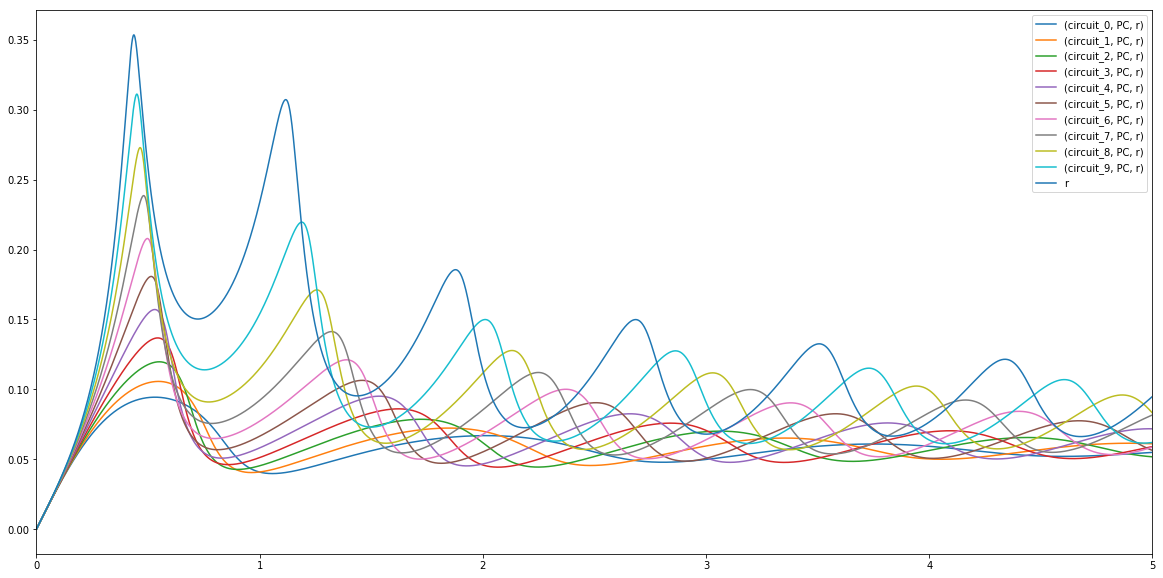

In [6]:
# 1) Access single data set
import h5py

with h5py.File(res_file) as file:
    data_dt = file["Config/dt"][()]
    print(data_dt)
    
# 2) Access results und result_map 
results = pd.read_hdf(res_file, key='/Results/results')
result_map = pd.read_hdf(res_file, key='/Results/result_map')

display(result_map.head())

plt.rcParams["figure.figsize"] = (20,10)
results.plot()

### Applying individual post processing to a CGS call

ClusterGridSearch offers the possibility to add arbitrary post processing that will be applied by each worker on its simulated model output.
Individual post processing can be added to the workers, applying the following two steps.

1) A new python script has to be created that will serve as worker execution file. Within this script, a new child class of the `ClusterWorkerTemplate` (imported from pyrates.utility.grid_search) has to be derived. Post processing can be added by modifing the `worker_postprocessing()` method. Using `self.results` and `self.result_map`, the user can access the workers `grid_search()` simulation result, as described above. The columns of the simulation output can ba arbitrarly altered and need to be stored in `self.processed_results` which is a is a pandas.DataFrame with the same column structure `self.results`. The `self.processed_results` DataFrames of all workers will be concatenated to a global result file whose location is returned by the `CGS.run()` function. Additional keyword arguments can be accepted via the `worker_kwargs` argument and can be added upon a `CGS.run()` call.

<b>Ensure that, if the worker script is executed, he customized worker class is instantiated and that its 'worker_init()' method is called.</b>
    
In the example below, after computing the model output for its respective parameter grid chunk, the worker iterates over all columns of the simulation results and computes the power spectral densitiy of the model paraemtrization output. The results of this computation are stored in the `self.processed_results` DataFrames that is send back to the master. In the case below, the original model output will not be saved.

Since `self.processed_results` is an empty `DataFrame`, if only a single value is written to each column, make sure to define an index first. 

In [ ]:
# my_cgs_worker.py

from pyrates.utility.grid_search import ClusterWorkerTemplate
from scipy.signal import welch


class MyWorker(ClusterWorkerTemplate):
    def worker_postprocessing(self, **worker_kwargs):
        for idx, data in self.results.iteritems():
            t = self.results.index.to_list()
            dt = t[1] - t[0]
            f, p = welch(data.to_numpy(), fs=1/dt, axis=0)
            self.processed_results.loc[:, idx] = p
        self.processed_results.index = f


if __name__ == "__main__":
    cgs_worker = MyWorker()
    cgs_worker.worker_init()


2) To use the created file as a cluster worker, its location <b>on the master</b> needs to be passed to the `CGS.run()` call via the `worker_file` argument as presented in the cell below.

,eta_op,eta_iin
circuit_0,-5.0,0.0
circuit_1,-4.0,1.0
circuit_2,-3.0,2.0
circuit_3,-2.0,3.0
circuit_4,-1.0,4.0


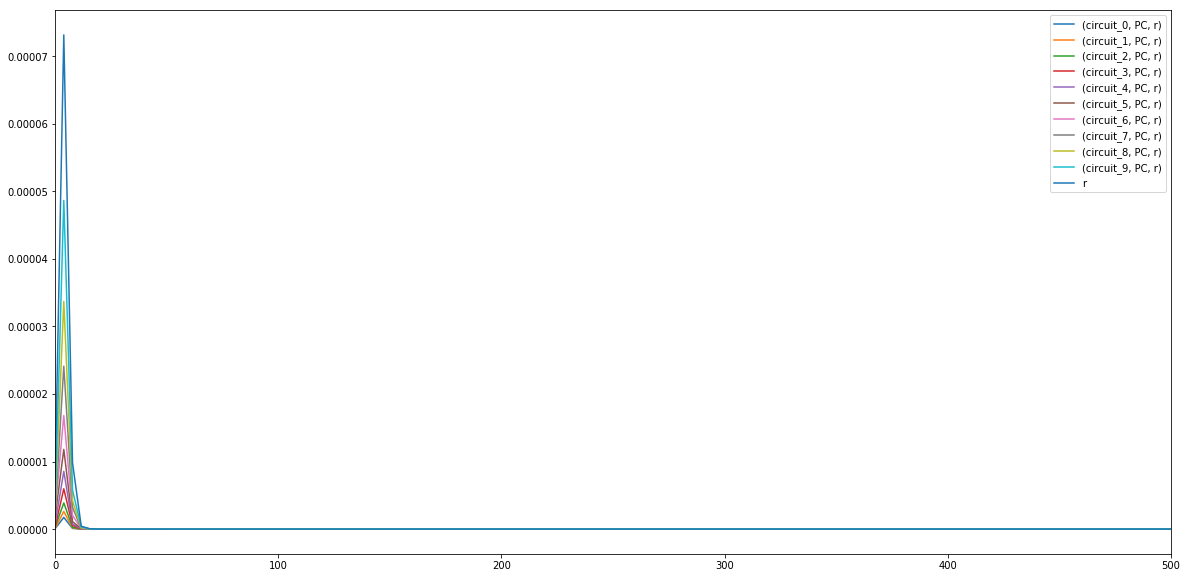

In [6]:
res_file = cgs.run(
    circuit_template=circuit_template,
    param_grid=param_grid,
    param_map=param_map,
    simulation_time=T,
    dt=dt,
    permute_grid=False,
    sampling_step_size=dts,
    inputs=inputs,
    outputs=outputs,
    chunk_size=5,  # [5, 10]
    worker_file=f'{os.getcwd()}/my_cgs_worker.py',
    gs_kwargs={
        "init_kwargs": {
            'backend': 'numpy',
            'solver': 'euler'
        },
        "njit": True,
        "parallel": False
    },
    worker_kwargs={"test": "test"}
)

results = pd.read_hdf(res_file, key=f'Results/results')
result_map = pd.read_hdf(res_file, key='Results/result_map')

display(result_map.head())

plt.rcParams["figure.figsize"] = (20,10)
results.plot()

### Execute workers in separate environment

The `CGS.run()` method offers the ability, to run worker scripts within a different environmant than the calling script.
For that purpose, a python executable path can be passed via the worker_env function argument.

In the example below, the worker script will be executed within an environment that contains the GPU version of tensorflow.
Additionally, PyRates' tensorflow backend will be used, instead of the numpy backend, specified in the init_kwargs.

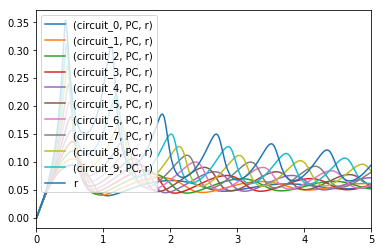

In [5]:
# Run simulation
################

res_file = cgs.run(
    circuit_template=circuit_template,
    param_grid=param_grid,
    param_map=param_map,
    simulation_time=T,
    dt=dt,
    permute_grid=False,
    sampling_step_size=dts,
    inputs=inputs,
    outputs=outputs,
    chunk_size=5,  # [5, 10]
    worker_env="/data/u_salomon_software/anaconda3/envs/PyRates_GPU/bin/python3",
    add_template_info=False,
    verbose=True,
    gs_kwargs={
        "init_kwargs": {
            'backend': 'tensorflow',
            'solver': 'euler'
        },
        "njit": True,
        "parallel": False
    },
)

# Load results
##############

results = pd.read_hdf(res_file, key=f'Results/results')
result_map = pd.read_hdf(res_file, key='Results/result_map')

results.plot()
plt.show()


### Common error messages

The most common error is a `FileNotFoundError` that is raised when reading results from an empty result file.
This can be traced back to a corrupted or defected worker file.
Output and error messages of the worker files will be printed to their respective local log file, but not to the terminal. It might therefore not directly become apparent what error was raised on the worker.
For that purpose, `ClusterGridSearch` catches the exit code of each worker.
Any python script that raises no error, exits with code 0.
An exit code unequal to zero indicates an incomplete computation.
Since the failure of a worker might only be temporary (e.g. worker was restarted during a computation), `CGS.run` call will not be interrupted if an error on one of the workers occurs.
Therefore, the computation finishes even if no results were created.

The two most common exit codes will be presented in the cells below.  
For a more detailed description of the error please see the respective local log file.

#### Corrupted worker file (exit code 1)
A worker file that terminates due to a `SyntaxError` will exit with code 1.
The easiest way to debug a worker file is to run its `worker_test` method as shown in the cell below.
The `worker_test` method creates a dummy result and a dummy result_grid and runs the customized post processing function on it. 
That way, only the `worker_postprocessing` method will be performed on the dummy data.
The structure of the dummy can be taken from the documentation.

In [4]:
# my_corrupted_worker.py

"""
Cluster worker raising a SyntaxError in line 14 since pd.DataFrame.loc is called using "()" instead of "[]"
"""

from pyrates.utility.grid_search import ClusterWorkerTemplate
from scipy.signal import welch


class MyWorker(ClusterWorkerTemplate):
    def worker_postprocessing(self, **worker_kwargs):
        for idx, data in self.results.iteritems():
            t = self.results.index.to_list()
            dt = t[1] - t[0]
            f, p = welch(data.to_numpy(), fs=1/dt, axis=0)
            self.processed_results.loc(:, idx) = p  # wrong
            # self.processed_results.loc[:, idx] = p  # correct
        self.processed_results.index = f


if __name__ == "__main__":
    cgs_worker = MyWorker()
    cgs_worker.worker_test()


SyntaxError: invalid syntax (<ipython-input-4-21b5f081e635>, line 17)

A more advanced debugging can be performed by calling the `worker_init` method, using an explicit config file and an explicit sub grid.
That way, the whole `worker_exec` method that is usually hidden in the core code will be executed.

In [ ]:
"""
Cluster worker raising a SyntaxError in line 14 since pd.DataFrame.loc is called using "()" instead of "[]"
"""

from pyrates.utility.grid_search import ClusterWorkerTemplate
from scipy.signal import welch


class MyWorker(ClusterWorkerTemplate):
    def worker_postprocessing(self, **worker_kwargs):
        for idx, data in self.results.iteritems():
            t = self.results.index.to_list()
            dt = t[1] - t[0]
            f, p = welch(data.to_numpy(), fs=1/dt, axis=0)
            self.processed_results.loc(:, idx) = p  # wrong
            # self.processed_results.loc[:, idx] = p  # correct
        self.processed_results.index = f


if __name__ == "__main__":
    cgs_worker = MyWorker()
    cgs_worker.worker_init(
        config_file="some_cgs_compute_dir/Config/DefaultConfig_0.yaml"
        subgrid="/some_cgs_compute_dir/Grids/Subgrids/DefaultGrid_0/nodename/nodename_Subgrid_0.h5"
        result_file="~/my_result.h5"
        build_dir=os.getcwd()
    )

#### Invalid worker file path (exit code 2)

If an invalid worker file is passed to the `CGS.run` call will exit with code 2.
In that case check if the correct path was specified

For demonstration purposes, a `CGS.run` is performed with the above mentioned worker that will introduce a syntax error. 

In [3]:
nodes = [
    'animals',
    'osttimor'
]

compute_dir = "~/Documents/CGS_presentation"

cgs = ClusterGridSearch(nodes, compute_dir=compute_dir)

T = 5.
dt = 1e-4
dts = 1e-3

param_grid = {'eta_op': np.linspace(-5, 5, 11),
              'eta_iin': np.linspace(0, 10, 11)}

param_map = {'eta_op': {'vars': ['Op_e/eta'],
                        'nodes': ['PC']},
             'eta_iin': {'vars': ['Op_i/eta'],
                         'nodes': ['IIN']}}

res_file = cgs.run(
    circuit_template="model_templates.montbrio.simple_montbrio.Net3",
    param_grid=param_grid,
    param_map=param_map,
    simulation_time=T,
    dt=dt,
    permute_grid=False,
    sampling_step_size=dts,
    inputs={"PC/Op_e/inp": np.ones((int(T/dt), 1))},
    outputs={'r': 'PC/Op_e/r'},
    chunk_size=6,  # [5, 10]
    worker_file=f'{os.getcwd()}/my_corrupted_worker.py',
    gs_kwargs={
        "init_kwargs": {
            'backend': 'numpy',
            'solver': 'euler'
        },
        "njit": True,
        "parallel": False
    },
    worker_kwargs={"test": "test"}
)

results = pd.read_hdf(res_file, key=f'Results/results')
result_map = pd.read_hdf(res_file, key='Results/result_map')

display(result_map.head())

plt.rcParams["figure.figsize"] = (20,10)
results.plot()

***NEW CLUSTER INSTANCE CREATED***
Compute ID: 191119-155051
Compute directory: /nobackup/spanien1/salomon/CGS/Benchmark_jup
Global logfile: /nobackup/spanien1/salomon/CGS/Benchmark_jup/Logs/191119-155051/Global_logfile.log

***CONNECTING TO NODES...***
'animals': Connection established!
CPU: Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz
Cores: 8
CPU freq: 3900.0 MHz
Total memory: 15901 MByte

'osttimor': Connection established!
CPU: Intel(R) Core(TM) i7-2600K CPU @ 3.40GHz
Cores: 8
CPU freq: 3800.0 MHz
Total memory: 16023 MByte

Nodes connected. Elapsed time: 1.817 seconds

***PREPARING PARAMETER GRID***
Done! Elapsed time: 0.126 seconds

***CHECKING PARAMETER GRID AND MAP FOR CONSISTENCY***
All parameter grid keys found in parameter map
Done! Elapsed time: 0.000 seconds

***CREATING CONFIG FILE***
Done! Elapsed time: 0.531 seconds

***CREATING GLOBAL RESULT FILE***
Done. Elapsed time: 0.318 seconds

***STARTING CLUSTER COMPUTATION***
[T]'animals': Fetching 6 indices: [0] - [5]
[T]'animals

FileNotFoundError: File  does not exist

/data/hu_salomon/PycharmProjects/MasterThesis/JupyterNotebooks

/data/hu_salomon/PycharmProjects/MasterThesis/JupyterNotebooks


In the cell below, the content of one of the workers local log file is shown.
Since the computation is restarted once if a worker exits with a code != 1, the error message occurs twice in its log file.

In [6]:
import os
print(os.getcwd())